## Data analysis: Linear model fit and volume corrected moments

In [1]:
using Random, Plots, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures

In [53]:
df = DataFrame(CSV.File("FISH_toShare_NoTSlabel_celldata_long_220620_simple_woMad3Outlier_withColDescription.csv"));

In [59]:
names(df);

In [60]:
df = df[:,[:sampleID,:gene,:NucleiCount,:Compartment,:CountMethod,:RNAperCell,:Cell_Length_um]];

In [61]:
# filter only for mad1WTGFP and NucleiCount = 1
dfa = subset(df, :gene => g -> g.=="mad1WTymEGFP", :NucleiCount => n -> n.==1)
# make cyto and nuc table separately.
dfcyto = subset(dfa, :Compartment=>c->c.=="Cytoplasm")
dfnuc = subset(dfa, :Compartment=>c->c.=="Nucleus")
# separate the 4 different samples
dfsN = [];dfsC = [];
samples = unique(dfa[!,:sampleID])
# add each to the vectors
for i in 1:4
    samp = samples[1]
    dftempN = subset(dfnuc, :sampleID=>S->S.==samples[i])
    dftempC = subset(dfcyto, :sampleID=>S->S.==samples[i])
    push!(dfsN,dftempN)
    push!(dfsC,dftempC)
end

In [62]:
dfsC;

If the moments I find differ from this then I know there's an issue! Let's collect the columns corresponding to the nuclear and cytoplasmic volumes and **counts** respectively.

In [63]:
names(dfsC[1])

7-element Vector{String}:
 "sampleID"
 "gene"
 "NucleiCount"
 "Compartment"
 "CountMethod"
 "RNAperCell"
 "Cell_Length_um"

In [85]:
n_vols = [dfsN[i][!,:Cell_Length_um] for i in 1:4]
c_vols = [dfsC[i][!,:Cell_Length_um] for i in 1:4]
n_ints = [dfsN[i][!,:RNAperCell] for i in 1:4]
c_ints = [dfsC[i][!,:RNAperCell] for i in 1:4];

In [143]:
Ns = [length(c_ints[i]) for i in 1:4];

For the linear model fits we use the Julia package GLM. This is a very convenient and fast way to construct linear models.

In [66]:
using GLM

Perform the linear model fits. Note in the below that our fitting parameters are stored in `npar` and `cpar` in the order `[intercept, gradient]`.

In [144]:
hcat(npars...)[1,:]

4-element Vector{Float64}:
  0.08612217893949915
 -0.25979006686629025
 -0.1013933851333162
  0.12071923280776861

In [112]:
nlms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsN[i]) for i in 1:4]
npars = [coef(nlms[i]) for i in 1:4]
cs = hcat(npars...)[1,:]; ds = hcat(npars...)[2,:]
clms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsC[i]) for i in 1:4]
cpars = [coef(clms[i]) for i in 1:4]
as = hcat(cpars...)[1,:]; bs = hcat(cpars...)[2,:]

4-element Vector{Float64}:
 0.6037905581610089
 0.4660886362796698
 0.47960260256122594
 0.37971856092996686

A quick look at the linear model fit itself will tell us some properties of the fit.

In [80]:
clms[1]

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

RNAperCell ~ 1 + Cell_Length_um

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)     -3.16679    0.240588   -13.16    <1e-36  -3.63882   -2.69475
Cell_Length_um   0.603791   0.0228683   26.40    <1e-99   0.558923   0.648658
─────────────────────────────────────────────────────────────────────────────

Now, to construct the volume corrected moments we first need to know the mean values for the volumes and intensities. Collect these from the data.

In [117]:
n_vol_avgs = [mean(n_vols[i]) for i in 1:4]
c_vol_avgs = [mean(c_vols[i]) for i in 1:4]
n_avgs = [mean(n_ints[i]) for i in 1:4]
c_avgs = [mean(c_ints[i]) for i in 1:4]

4-element Vector{Float64}:
 3.094988234996555
 2.6687301433055026
 2.9580443633353566
 2.610546234022337

Note that even the means of the cytoplasmic can vary quite significantly between the replicates. As can the observed mean cell volumes in each experiment.

We know theoretically that to first order volume corrections to the means are nil. Let's just clarify this.

In [114]:
ds

4-element Vector{Float64}:
 0.0246344002185223
 0.05869752331164116
 0.04127424654051073
 0.01671396006186987

In [116]:
vc_mean_ns = [cs[i] + n_vol_avgs[i]*ds[i] for i in 1:4]
vc_mean_cs = [as[i] + c_vol_avgs[i]*bs[i] for i in 1:4]
# vc_mean_cs = a + c_vol_avg*b

4-element Vector{Float64}:
 3.094988234996556
 2.6687301433055017
 2.958044363335354
 2.610546234022335

In [124]:
μ20s = [moment(n_ints[i], 2, n_avgs[i]) for i in 1:4];
μ02s = [moment(c_ints[i], 2, c_avgs[i]) for i in 1:4];
μ20Ωs = [moment(n_vols[i], 2, n_vol_avgs[i]) for i in 1:4];
μ02Ωs = [moment(c_vols[i], 2, c_vol_avgs[i]) for i in 1:4];

In [126]:
μ20s_i = [μ20s[i] - ds[i]^2 * μ20Ωs[i] for i in 1:4]
μ02s_i = [μ02s[i] - bs[i]^2 * μ02Ωs[i] for i in 1:4];

Clearly the volume corrected means are simply the means if one averaged over the data. Can now store the values for the VC FF's along with the mean cyto #.

In [139]:
nuc_FFs = μ20s_i./vc_mean_ns

4-element Vector{Float64}:
 0.9558150606258131
 0.9926999917678181
 0.9744213797386201
 0.9971426022451758

In [140]:
cyto_FFs = μ02s_i./vc_mean_cs

4-element Vector{Float64}:
 0.6129543833434675
 0.755756819406369
 0.6613100531460414
 0.5879024967862989

In [138]:
cyto_means = vc_mean_cs

4-element Vector{Float64}:
 3.094988234996556
 2.6687301433055017
 2.958044363335354
 2.610546234022335

# Now for the ABC...

In [131]:
using Random, Plots, LaTeXStrings, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures, Revise, GpABC, JLD2, FileIO

In [132]:
hypars = [3,3]; # [S,R]
# pf defined for the priors (see SI).
pf = (hypars[1]-1)/2

1.0

In [133]:
Plots.theme(:dao)
Plots.gr_cbar_width[] = 0.01;

In [135]:
Revise.track("/home/jamesh/GitHub/volume-inference-take-2/SSA-basic.jl")
include("/home/jamesh/GitHub/volume-inference-take-2/SSA-basic.jl")
using .SSAnonVD

In [136]:
pal = cgrad(:tol_muted);
cpal = [pal[i] for i in 1/7:1/7:1.0]
population_colors = cpal

In [150]:
tdeg = 1;
texpt(kA,kB,kC,S,R) = 1/kC;
tinit(kA,kB,kC,S,R) = (1/kB)+(S-1)/kA;

In [151]:
function sim_time(pars)
    kA, kB, kC = pars;
    return 10*maximum([1,texpt(pars...,hypars...),tinit(pars...,hypars...)])
end

sim_time (generic function with 1 method)

In [153]:
function new_distance(traj1::Matrix, traj2::Matrix)
    return sum([bs_vec[i]^(-1)*((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end
function new_distance(traj1::Vector, traj2::Vector)
    return sum([bs_vec[i]^(-1)*((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end

new_distance (generic function with 2 methods)

## Sample 1 of 4

In [160]:
sn = 1;
bs_vec = [cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]];

In [166]:
function simulator_fn_1(pars)
    op = SSA(Ns[1], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_1 (generic function with 1 method)

Let's look at the value of the objective function for something close to an optimum value. This informs what our threshold schedule for the ABC will be.

In [167]:
new_distance(simulator_fn_1([2.54,3.64,20.0]),reshape([cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]],(3,1)))

0.053184934191168286

In [169]:
# ABC priors
priors_1 = [Uniform(pf*0.5,pf*10.5), Uniform(0.5, 40.5), Uniform(20,220)]

# number of particles
n_particles = 1

# ABC hpars
threshold_schedule_1 = [50.0,10.0,5.0,1.0,0.5,0.2,0.1]

7-element Vector{Float64}:
 50.0
 10.0
  5.0
  1.0
  0.5
  0.2
  0.1

In [170]:
sim_abcsmc_res_1 = SimulatedABCSMC(reshape([cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]],(3,1)),
    simulator_fn_1,
    priors_1,
    threshold_schedule_1,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true);

[ Info: GpABC rejection simulation. ϵ = 50.0.
[ Info: GpABC SMC simulation ϵ = 10.0
[ Info: GpABC SMC simulation ϵ = 5.0
[ Info: GpABC SMC simulation ϵ = 1.0
[ Info: GpABC SMC simulation ϵ = 0.5
[ Info: GpABC SMC simulation ϵ = 0.2
[ Info: GpABC SMC simulation ϵ = 0.1


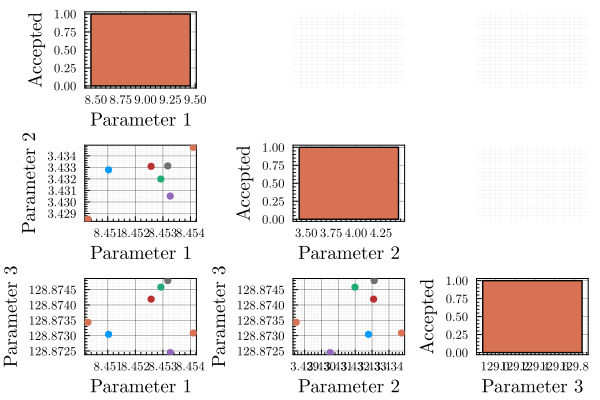

In [171]:
plot(sim_abcsmc_res_1)

In [175]:
save("./jld2-res/S$(hypars[1])R$(hypars[2])_mad1WTGFP_samp1.jld2", "ABC", sim_abcsmc_res_1)

## Sample 2 of 4

In [176]:
sn = 2;
bs_vec = [cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]];

In [177]:
function simulator_fn_2(pars)
    op = SSA(Ns[2], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_2 (generic function with 1 method)

Let's look at the value of the objective function for something close to an optimum value. This informs what our threshold schedule for the ABC will be.

In [194]:
new_distance(simulator_fn_2([2.54,3.64,20.0]),reshape([cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]],(3,1)))

0.05904958669797888

In [195]:
# ABC priors
priors_1 = [Uniform(pf*0.5,pf*10.5), Uniform(0.5, 40.5), Uniform(20,220)]

# number of particles
n_particles = 1

# ABC hpars
threshold_schedule_1 = [50.0,10.0,5.0,1.0,0.5,0.2,0.1]

7-element Vector{Float64}:
 50.0
 10.0
  5.0
  1.0
  0.5
  0.2
  0.1

In [196]:
sim_abcsmc_res_2 = SimulatedABCSMC(reshape([cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]],(3,1)),
    simulator_fn_2,
    priors_1,
    threshold_schedule_1,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true);

[ Info: GpABC rejection simulation. ϵ = 50.0.
[ Info: GpABC SMC simulation ϵ = 10.0
[ Info: GpABC SMC simulation ϵ = 5.0
[ Info: GpABC SMC simulation ϵ = 1.0


LoadError: InterruptException:

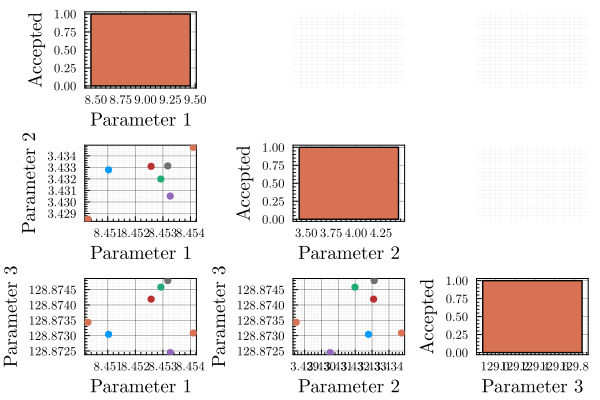

In [171]:
plot(sim_abcsmc_res_2)

In [175]:
save("./jld2-res/S$(hypars[1])R$(hypars[2])_mad1WTGFP_samp2.jld2", "ABC", sim_abcsmc_res_2)

## Sample 3 of 4

In [197]:
sn = 3;
bs_vec = [cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]];

In [199]:
function simulator_fn_3(pars)
    op = SSA(Ns[3], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_3 (generic function with 1 method)

Let's look at the value of the objective function for something close to an optimum value. This informs what our threshold schedule for the ABC will be.

In [202]:
new_distance(simulator_fn_3([2.54,3.64,20.0]),reshape([cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]],(3,1)))

0.0354768402561021

In [204]:
# ABC priors
priors_1 = [Uniform(pf*0.5,pf*10.5), Uniform(0.5, 40.5), Uniform(20,220)]

# number of particles
n_particles = 1

# ABC hpars
threshold_schedule_1 = [50.0,10.0,5.0,1.0,0.5,0.2,0.1]

7-element Vector{Float64}:
 50.0
 10.0
  5.0
  1.0
  0.5
  0.2
  0.1

In [205]:
sim_abcsmc_res_3 = SimulatedABCSMC(reshape([cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]],(3,1)),
    simulator_fn_3,
    priors_1,
    threshold_schedule_1,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true);

[ Info: GpABC rejection simulation. ϵ = 50.0.
[ Info: GpABC SMC simulation ϵ = 10.0
[ Info: GpABC SMC simulation ϵ = 5.0
[ Info: GpABC SMC simulation ϵ = 1.0
[ Info: GpABC SMC simulation ϵ = 0.5
[ Info: GpABC SMC simulation ϵ = 0.2
[ Info: GpABC SMC simulation ϵ = 0.1


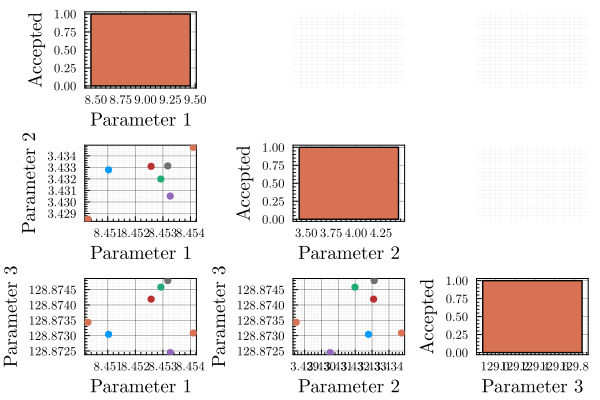

In [171]:
plot(sim_abcsmc_res_3)

In [175]:
save("./jld2-res/S$(hypars[1])R$(hypars[2])_mad1WTGFP_samp3.jld2", "ABC", sim_abcsmc_res_3)

## Sample 4 of 4

In [206]:
sn = 4;
bs_vec = [cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]];

In [207]:
function simulator_fn_4(pars)
    op = SSA(Ns[4], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_4 (generic function with 1 method)

Let's look at the value of the objective function for something close to an optimum value. This informs what our threshold schedule for the ABC will be.

In [211]:
new_distance(simulator_fn_1([2.54,3.64,20.0]),reshape([cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]],(3,1)))

0.02057390301005212

In [212]:
# ABC priors
priors_1 = [Uniform(pf*0.5,pf*10.5), Uniform(0.5, 40.5), Uniform(20,220)]

# number of particles
n_particles = 1

# ABC hpars
threshold_schedule_1 = [50.0,10.0,5.0,1.0,0.5,0.2,0.1]

7-element Vector{Float64}:
 50.0
 10.0
  5.0
  1.0
  0.5
  0.2
  0.1

In [213]:
sim_abcsmc_res_4 = SimulatedABCSMC(reshape([cyto_means[sn],nuc_FFs[sn],cyto_FFs[sn]],(3,1)),
    simulator_fn_4,
    priors_1,
    threshold_schedule_1,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true);

[ Info: GpABC rejection simulation. ϵ = 50.0.
[ Info: GpABC SMC simulation ϵ = 10.0
[ Info: GpABC SMC simulation ϵ = 5.0
[ Info: GpABC SMC simulation ϵ = 1.0
[ Info: GpABC SMC simulation ϵ = 0.5
[ Info: GpABC SMC simulation ϵ = 0.2


LoadError: InterruptException:

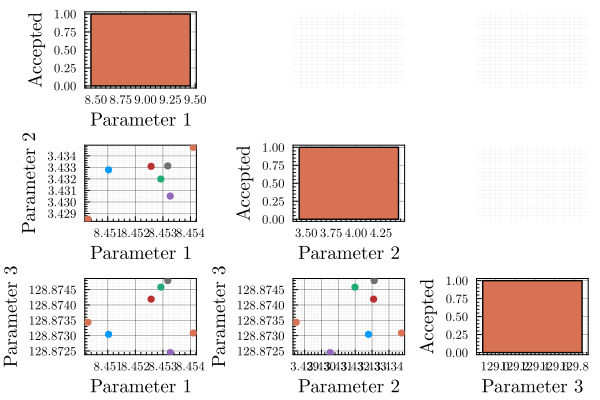

In [214]:
plot(sim_abcsmc_res_1)

In [175]:
save("./jld2-res/S$(hypars[1])R$(hypars[2])_mad1WTGFP_samp4.jld2", "ABC", sim_abcsmc_res_4)